In [1]:
import numpy as np
import pandas as pd
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20
plt.rcParams['font.size'] = 20
plt.rcParams['font.family'] = 'serif'
plt.rcParams['text.usetex'] = True

In [16]:
palette = sns.color_palette('deep')
palette

[(0.2980392156862745, 0.4470588235294118, 0.6901960784313725),
 (0.8666666666666667, 0.5176470588235295, 0.3215686274509804),
 (0.3333333333333333, 0.6588235294117647, 0.40784313725490196),
 (0.7686274509803922, 0.3058823529411765, 0.3215686274509804),
 (0.5058823529411764, 0.4470588235294118, 0.7019607843137254),
 (0.5764705882352941, 0.47058823529411764, 0.3764705882352941),
 (0.8549019607843137, 0.5450980392156862, 0.7647058823529411),
 (0.5490196078431373, 0.5490196078431373, 0.5490196078431373),
 (0.8, 0.7254901960784313, 0.4549019607843137),
 (0.39215686274509803, 0.7098039215686275, 0.803921568627451)]

In [4]:
myColors = ['#784421', '#f1b300']

# Probability function

$$P(x) = \frac{1}{1 + e^{-A(x-K)}}$$

In [5]:
def sigFunc(x, A, K):
    return (1 + np.exp(-A*(x-K)))**-1

In [6]:
A_V = 2
K_V = 3
A_T = 1e-5
K_T = 1975136

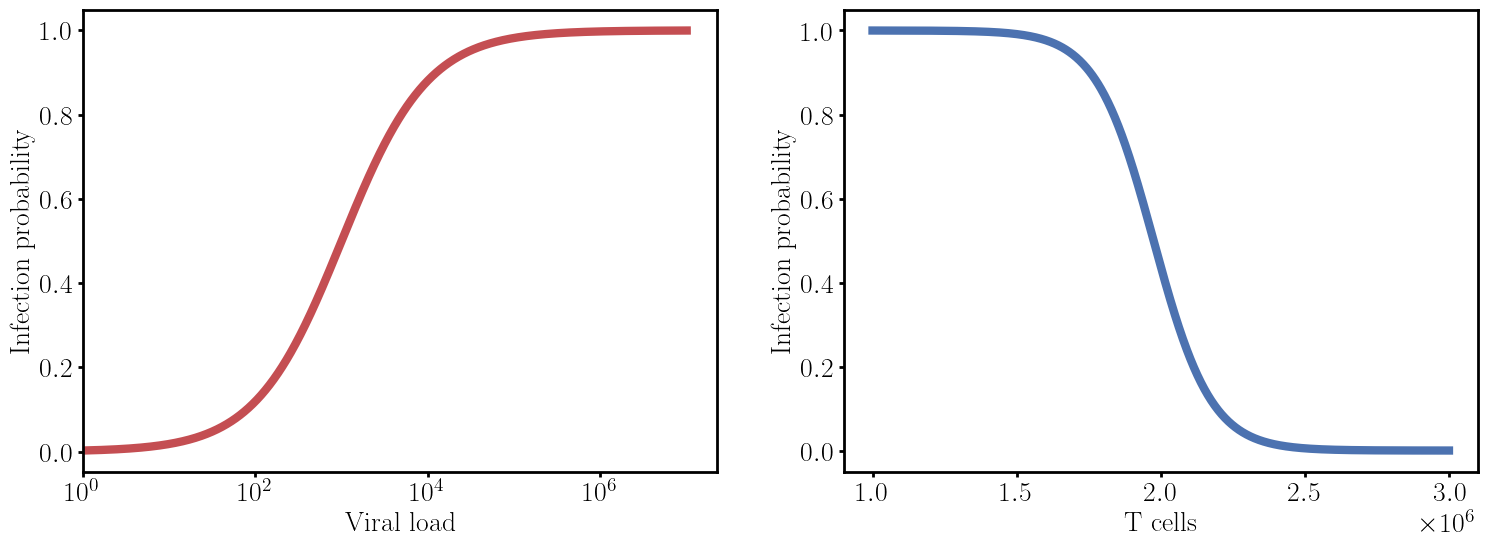

In [7]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(18,6),facecolor='white')

xx = np.linspace(0, 7, num=1000)
x = 10**(xx)
yy1 = sigFunc(xx, A_V, K_V)

axs[0].plot(x, yy1, lw=6, color=palette[3])
axs[0].set_xlabel('Viral load')
axs[0].set_ylabel('Infection probability')
axs[0].set_xscale('log')
axs[0].set_xlim((1))

xx = np.linspace(1e6, 3e6, num=1000)
yy2 = 1 - sigFunc(xx, A_T, K_T)

axs[1].plot(xx, yy2, lw=6, color=palette[0])
axs[1].set_xlabel('T cells')
axs[1].set_ylabel('Infection probability')

for axis in ['top','bottom','left','right']:
    axs[0].spines[axis].set_linewidth(2)
    axs[1].spines[axis].set_linewidth(2)

axs[0].xaxis.set_tick_params(width=2)
axs[0].yaxis.set_tick_params(width=2)

axs[1].xaxis.set_tick_params(width=2)
axs[1].yaxis.set_tick_params(width=2)

# plt.savefig('probFunction.png')

plt.show()

# Simulations
## Within-host model:

\begin{align}
V' &= p V \left( 1 - \frac{V}{k_v} \right) - c_T V T - c_M M V - c_G G V - c V \\
T' &= r_T T \left( \frac{V^2}{V^2 + k_T^2} \right) - \delta_T (T - T(0)) \\
B' &= \frac{r_B V - B}{\tau_B} \\
M' &= r_M B - (q + \delta_M) M \\
G' &= r_q M \left( 1 - \frac{M}{K_q} \right) + r_G B - \delta_G G
\end{align}

In [8]:
def within_model(y,t):
   
    # Patient 1: non-severe
    cm = 0.006038
    cg = 0.04077
    tauB = 6.483603
    rM = 0.001248
    q = 0.003339
    rG = 0.000303
    kq = 365.74194
    rQ = 0.009188
    rB = 0.104897
  
    # Fixed parameters
    p = 6.11
    kv = 1e8
    ct = 0.78e-6
    c = 2.4
    rT = 0.281
    kt = 3.16e4
    delT = 0.1
    T0 = 1e6    
    delM = 0.06931
    delG = 0.027725
    
    V, T, B, M, G = y # Initial conditions

    if V < 0.0:
        V = 0.0
    if B < 0.0:
        B = 0.0
    if M < 0.0:
        M = 0.0
    if G < 0.0:
        G = 0.0
    
    dV = p*V*(1 - (V/kv)) - ct*V*T - c*V - cm*M*V - cg*G*V
    dT = delT*T0 +rT*T*(V**2/(V**2 + kt**2)) - delT*T
    dB = (rB*V - B)/tauB
    dM = rM*B - q*M - delM*M
    dG = rQ*M*(1 - (M/kq)) + rG*B - delG*G
    
    dydt = np.array([dV, dT, dB, dM, dG])
    
    return dydt

In [9]:
V0 = 1.0
T0 = 1e6
B0 = 0.0
M0 = 0.0
G0 = 0.0
    
intState = [V0, T0, B0, M0, G0]

timeStep = 0.01
endDay = 25
tt = np.arange(0, endDay, timeStep)

In [10]:
levels = odeint(within_model, intState, tt)

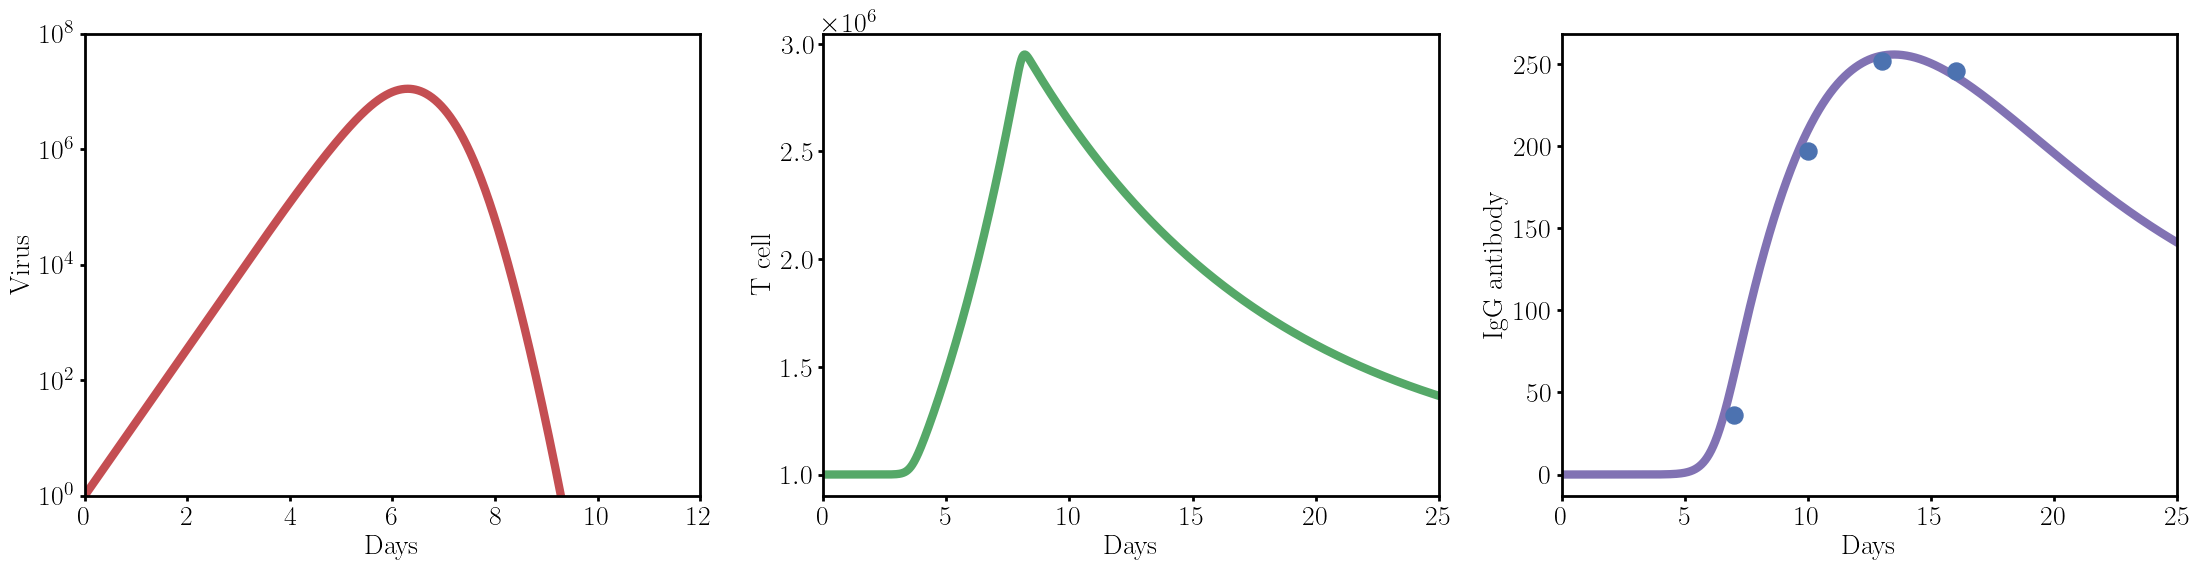

In [11]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(27,6), facecolor='white')

axs[0].plot(tt, levels[:,0], lw=6, color=palette[3])
axs[0].set_yscale('log')
axs[0].set_ylim((1,10**8))
axs[0].set_ylabel('Virus')
axs[0].set_xlim((0,12))
axs[0].set_xlabel('Days')

axs[1].plot(tt, levels[:,1], lw=6, color=palette[2])
axs[1].set_ylabel('T cell')
axs[1].set_xlim((0,25))
axs[1].set_xlabel('Days')

axs[2].plot(tt, levels[:,4], lw=6, color=palette[4], zorder=-1)
axs[2].scatter([7,10,13,16],[36,197,252,246], s=150, color=palette[0], zorder=1)
axs[2].set_ylabel('IgG antibody')
axs[2].set_xlim((0,25))
axs[2].set_xlabel('Days')

for axis in ['top','bottom','left','right']:
    axs[0].spines[axis].set_linewidth(2)
    axs[1].spines[axis].set_linewidth(2)
    axs[2].spines[axis].set_linewidth(2)

axs[0].xaxis.set_tick_params(width=2)
axs[0].yaxis.set_tick_params(width=2)

axs[1].xaxis.set_tick_params(width=2)
axs[1].yaxis.set_tick_params(width=2)

axs[2].xaxis.set_tick_params(width=2)
axs[2].yaxis.set_tick_params(width=2)

# plt.setp(axs, xlim=(0,endDay), xlabel='Days')

# plt.savefig('model.png')

plt.show()

/tmp/ipykernel_3254/56274475.py:3: RuntimeWarning: invalid value encountered in log10
  yy1 = sigFunc(np.log10(levels[:,0]), A_V, K_V)


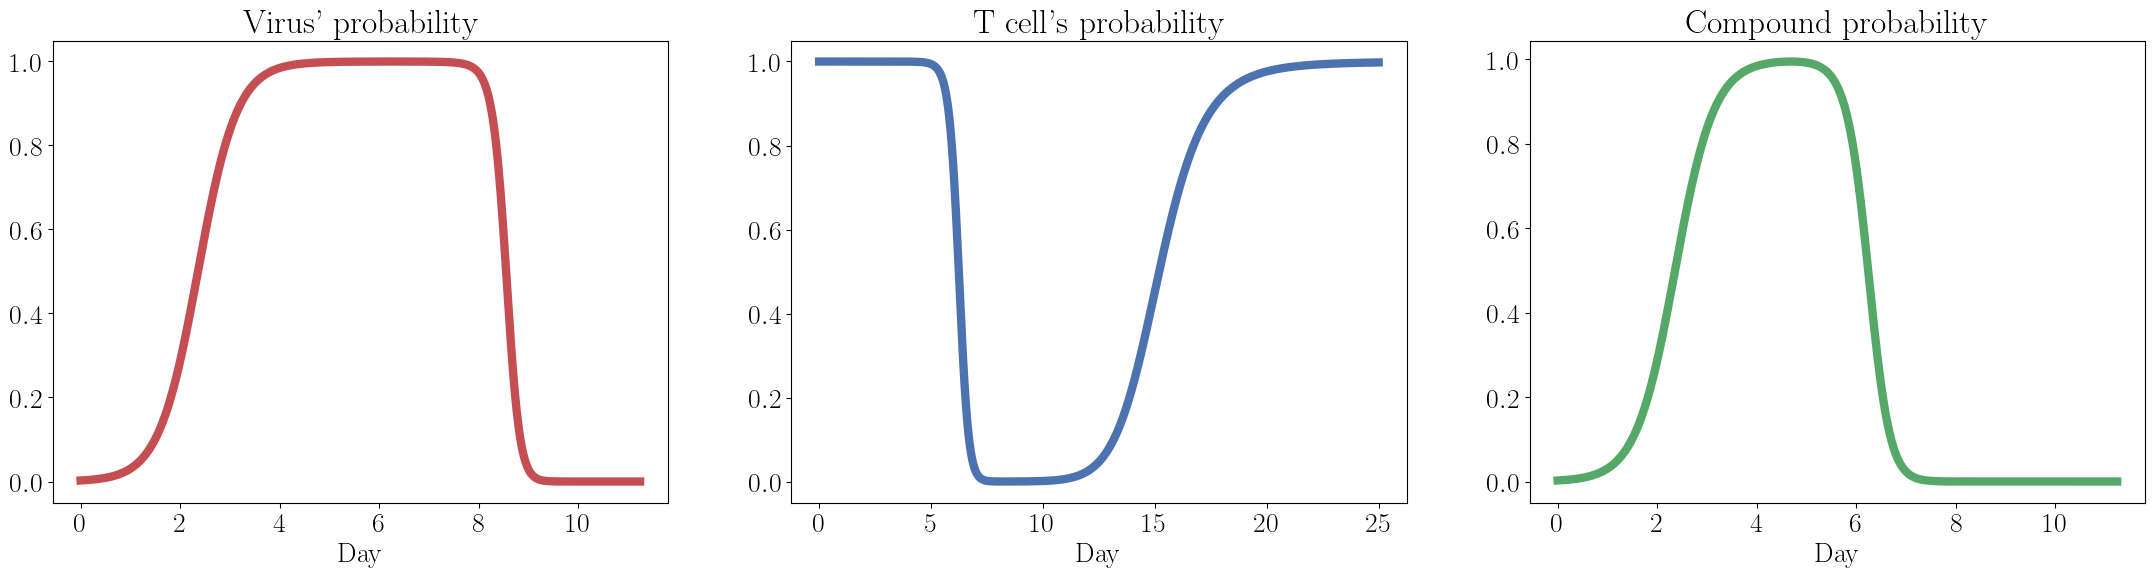

In [12]:
tt = np.arange(0, endDay, timeStep)

yy1 = sigFunc(np.log10(levels[:,0]), A_V, K_V)
yy2 = 1 - sigFunc(levels[:,1], A_T, K_T)

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(27,6))

axs[0].plot(tt, yy1, lw=6, color=palette[3])
axs[0].set_title('Virus\' probability')
axs[0].set_xlabel('Day')

axs[1].plot(tt, yy2, lw=6, color=palette[0])
axs[1].set_title('T cell\'s probability')
axs[1].set_xlabel('Day')

axs[2].plot(tt, yy1*yy2, lw=6, color=palette[2])
axs[2].set_title('Compound probability')
axs[2].set_xlabel('Day')

plt.show()

/tmp/ipykernel_3254/2149520231.py:5: RuntimeWarning: invalid value encountered in log10
  yy1 = sigFunc(np.log10(levels[:,0]), A_V, K_V)


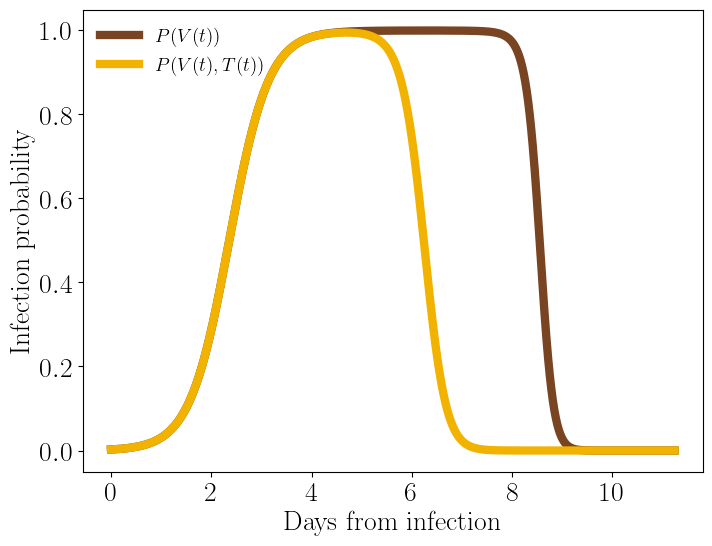

In [13]:
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(8,6), facecolor='white')

tt = np.arange(0, endDay, timeStep)

yy1 = sigFunc(np.log10(levels[:,0]), A_V, K_V)
yy2 = 1 - sigFunc(levels[:,1], A_T, K_T)

axs.plot(tt, yy1, lw=6, color=myColors[0], label='$P(V(t))$')
axs.plot(tt, yy1*yy2, lw=6, color=myColors[1], label='$P(V(t), T(t))$')
axs.set_xlabel('Days from infection')
axs.set_ylabel('Infection probability')

plt.legend(loc='upper left', fontsize=14, frameon=False)

# plt.savefig('timeProbFunction.pdf')

plt.show()

### $P = P(V, T)$

In [14]:
# Parameters
nodes = 1001
numSims = 250 # Number of simulations for statistics

In [15]:
dfLastN_V = pd.DataFrame(np.arange(numSims), columns=['N of Sim'])
dfLastN_T = pd.DataFrame(np.arange(numSims), columns=['N of Sim'])

dfFreq_V = pd.DataFrame(np.arange(1,nodes), columns=['Node'])
dfFreq_T = pd.DataFrame(np.arange(1,nodes), columns=['Node'])

dfLastN_V['Prob'] = 'P(V)'
dfLastN_T['Prob'] = 'P(V,T)'

dfFreq_V['Prob'] = 'P(V)'
dfFreq_T['Prob'] = 'P(V,T)'

In [71]:
%%time

for dayStep in [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]:
    print(f'Simulating {dayStep} day steps')

    for pVT in [0,1]:

        freqNode = np.zeros(nodes - 1)
        #infecDay = np.full((numSims, nodes-1), -1)
        lastNode = np.zeros(numSims)

        for ss in range(numSims):
            nn = 0
            time = 0.0
            infecTime = 0.0

            while nn < nodes - 1:            
                infecTime += dayStep
                time += dayStep        
                idx = int(infecTime/timeStep)

                if idx >= levels.shape[0]:
                    break

                V = levels[idx][0]
                T = levels[idx][1]
                if V < 1:
                    continue

                # Here, it decides if infects the next node
                pV = sigFunc(np.log10(V), A_V, K_V)
                if pVT == 1:
                    pT = sigFunc(T, A_T, K_T)
                    prob = pV*(1-pT)
                else:
                    prob = pV

                if np.random.uniform() < prob:
                    nn += 1
                    #infecDay[ss][nn-1] = time
                    freqNode[nn-1] += 1
                    infecTime = 0.0

            lastNode[ss] = nn

        if pVT == 0:
            dfFreq_V[f'{dayStep} Day'] = freqNode
            dfLastN_V[f'{dayStep} Day'] = lastNode
        else:
            dfFreq_T[f'{dayStep} Day'] = freqNode
            dfLastN_T[f'{dayStep} Day'] = lastNode

Simulating 1 day steps
Simulating 2 day steps
Simulating 3 day steps
Simulating 4 day steps
Simulating 5 day steps
Simulating 6 day steps
Simulating 7 day steps
Simulating 8 day steps
Simulating 9 day steps
Simulating 10 day steps
CPU times: user 10.9 s, sys: 0 ns, total: 10.9 s
Wall time: 10.9 s


In [72]:
dfFreq_V.to_csv('infecFreqs_V.dat', sep='\t',
                columns=['Node', '1 Day', '2 Day', '3 Day', '4 Day', '5 Day', '6 Day', '7 Day', '8 Day', '9 Day', '10 Day'],
                index=False)
dfFreq_T.to_csv('infecFreqs_T.dat', sep='\t',
                columns=['Node', '1 Day', '2 Day', '3 Day', '4 Day', '5 Day', '6 Day', '7 Day', '8 Day', '9 Day', '10 Day'],
                index=False)

In [73]:
dfLastN = pd.concat([dfLastN_V,dfLastN_T])
dfFreq = pd.concat([dfFreq_V,dfFreq_T])

In [16]:
dfLastN

,N of Sim,Prob,1 Day,2 Day,3 Day,4 Day,5 Day,6 Day,7 Day,8 Day,9 Day,10 Day
0,0,P(V),1000.0,1000.0,1000.0,826.0,496.0,871.0,600.0,101.0,0.0,0.0
1,1,P(V),1000.0,1000.0,1000.0,1000.0,254.0,1000.0,1000.0,15.0,0.0,0.0
2,2,P(V),1000.0,1000.0,1000.0,1000.0,164.0,1000.0,1000.0,68.0,0.0,0.0
3,3,P(V),1000.0,1000.0,1000.0,432.0,101.0,1000.0,1000.0,60.0,0.0,0.0
4,4,P(V),1000.0,1000.0,1000.0,576.0,1.0,801.0,1000.0,34.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
995,995,"P(V,T)",1000.0,429.0,3.0,23.0,23.0,3.0,0.0,0.0,0.0,0.0
996,996,"P(V,T)",1000.0,155.0,49.0,20.0,77.0,7.0,2.0,0.0,0.0,0.0
997,997,"P(V,T)",1000.0,3.0,2.0,110.0,120.0,6.0,0.0,0.0,0.0,0.0
998,998,"P(V,T)",1000.0,137.0,40.0,14.0,65.0,1.0,0.0,0.0,0.0,0.0


In [17]:
dfFreq

,Node,Prob,1 Day,2 Day,3 Day,4 Day,5 Day,6 Day,7 Day,8 Day,9 Day,10 Day
0,1,P(V),1000.0,1000.0,1000.0,1000.0,996.0,1000.0,999.0,975.0,27.0,0.0
1,2,P(V),1000.0,1000.0,1000.0,1000.0,993.0,1000.0,998.0,949.0,2.0,0.0
2,3,P(V),1000.0,1000.0,1000.0,999.0,992.0,1000.0,998.0,920.0,1.0,0.0
3,4,P(V),1000.0,1000.0,1000.0,999.0,991.0,999.0,998.0,902.0,0.0,0.0
4,5,P(V),1000.0,1000.0,1000.0,999.0,991.0,998.0,997.0,882.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
995,996,"P(V,T)",996.0,56.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
996,997,"P(V,T)",996.0,56.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
997,998,"P(V,T)",996.0,56.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
998,999,"P(V,T)",996.0,56.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Plot

In [18]:
dfLastN = dfLastN.rename({'1 Day':1, '2 Day':2, '3 Day':3, '4 Day':4, '5 Day':5,
                          '6 Day':6, '7 Day':7, '8 Day':8, '9 Day':9, '10 Day':10}, axis=1)

In [19]:
dfLastN_melt = pd.melt(dfLastN, id_vars=['N of Sim', 'Prob'],
                       value_vars=[2, 3, 4, 5, 6, 7, 8],
                       var_name='Contact', value_name='Last infected node')

In [20]:
dfLastN_meltLess = dfLastN_melt.copy()

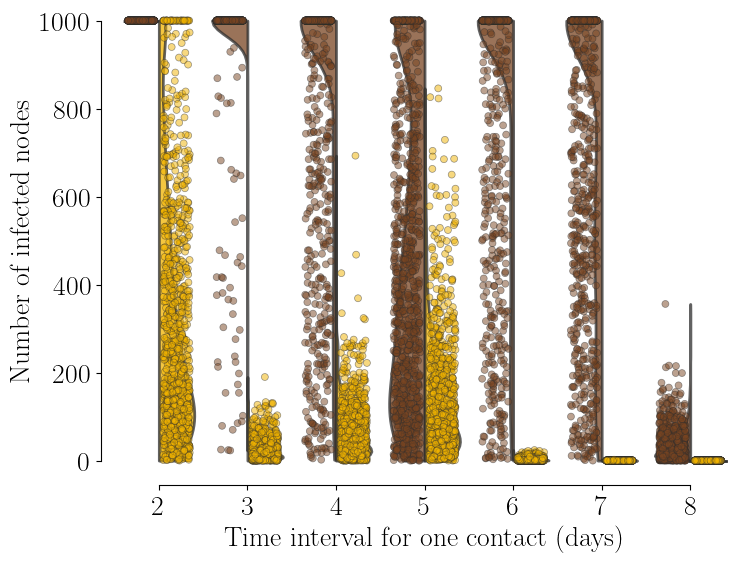

In [29]:
myColors = ['#784421', '#f1b300']
fig, ax =  plt.subplots(1,1, figsize=(8,6), sharey = True, facecolor='white')

g = sns.violinplot(x='Contact', y='Last infected node', hue='Prob', data=dfLastN_melt, 
               cut=0, split=True, density_norm='count', inner=None, palette=myColors, 
               saturation=1.0, linewidth=2, legend=False)
plt.setp(ax.collections, alpha=0.75)

sns.stripplot(x='Contact', y='Last infected node', hue='Prob', data=dfLastN_meltLess,
              jitter=0.3, dodge=True, s=5, marker='o', linewidth=0.5, alpha=0.5, 
              palette=myColors, legend=False)

ax.set(ylim=(-25, 1025))
sns.despine(offset=10, trim=True);

ax.set_xlabel('Time interval for one contact (days)')
ax.set_ylabel('Number of infected nodes')

# plt.savefig('violinLastN.pdf')

plt.show()

# Probability distributions

In [15]:
levels = odeint(within_model, intState, tt)

VV = levels[:,0]
TT = levels[:,1]

In [16]:
probV = sigFunc(np.log10(VV), A_V, K_V)
probT = 1 - sigFunc(TT, A_T, K_T)
probVT = probV*probT

/tmp/ipykernel_20028/3211400731.py:1: RuntimeWarning: invalid value encountered in log10
  probV = sigFunc(np.log10(VV), A_V, K_V)


In [17]:
xx = np.arange(1, 1001, 1)

In [18]:
p1 = probV[int(1/timeStep)]
p2 = probV[int(2/timeStep)]
p3 = probV[int(3/timeStep)]
p4 = probV[int(4/timeStep)]
p5 = probV[int(5/timeStep)]
p6 = probV[int(6/timeStep)]
p7 = probV[int(7/timeStep)]
p8 = probV[int(8/timeStep)]
p9 = probV[int(9/timeStep)]

e1 = 1 - (1-p1)*(1-p2)*(1-p3)*(1-p4)*(1-p5)*(1-p6)*(1-p7)*(1-p8)*(1-p9)
e2 = 1 - (1-p2)*(1-p4)*(1-p6)*(1-p8)
e3 = 1 - (1-p3)*(1-p6)*(1-p9)
e4 = 1 - (1-p4)*(1-p8)
e5 = p5
e6 = p6
e7 = p7
e8 = p8

print('P(V):')
print(f'every 1 = {e1}')
print(f'every 2 = {e2}')
print(f'every 3 = {e3}')
print(f'every 4 = {e4}')
print(f'every 5 = {e5}')
print(f'every 6 = {e6}')
print(f'every 7 = {e7}')
print(f'every 8 = {e8}')

yy1_V = e1**xx
yy2_V = e2**xx
yy3_V = e3**xx
yy4_V = e4**xx
yy5_V = e5**xx
yy6_V = e6**xx
yy7_V = e7**xx
yy8_V = e8**xx

P(V):
every 1 = 0.9999999999999841
every 2 = 0.99999989473577
every 3 = 0.9999455688133385
every 4 = 0.9995698250074775
every 5 = 0.9984029811927292
every 6 = 0.9996568087720271
every 7 = 0.9993856252681136
every 8 = 0.9723665883869947


In [19]:
p1 = probVT[int(1/timeStep)]
p2 = probVT[int(2/timeStep)]
p3 = probVT[int(3/timeStep)]
p4 = probVT[int(4/timeStep)]
p5 = probVT[int(5/timeStep)]
p6 = probVT[int(6/timeStep)]
p7 = probVT[int(7/timeStep)]
p8 = probVT[int(8/timeStep)]
p9 = probVT[int(9/timeStep)]

e1 = 1 - (1-p1)*(1-p2)*(1-p3)*(1-p4)*(1-p5)*(1-p6)*(1-p7)*(1-p8)*(1-p9)
e2 = 1 - (1-p2)*(1-p4)*(1-p6)*(1-p8)
e3 = 1 - (1-p3)*(1-p6)*(1-p9)
e4 = 1 - (1-p4)*(1-p8)
e5 = p5
e6 = p6
e7 = p7
e8 = p8

print('P(V,T):')
print(f'every 1 = {e1}')
print(f'every 2 = {e2}')
print(f'every 3 = {e3}')
print(f'every 4 = {e4}')
print(f'every 5 = {e5}')
print(f'every 6 = {e6}')
print(f'every 7 = {e7}')
print(f'every 8 = {e8}')

yy1_T = e1**xx
yy2_T = e2**xx
yy3_T = e3**xx
yy4_T = e4**xx
yy5_T = e5**xx
yy6_T = e6**xx
yy7_T = e7**xx
yy8_T = e8**xx

P(V,T):
every 1 = 0.9999965190721373
every 2 = 0.997113981078834
every 3 = 0.958154021414242
every 4 = 0.9842081437130272
every 5 = 0.9921976729791658
every 6 = 0.7436954384247819
every 7 = 0.023259860523024624
every 8 = 8.611157061309883e-05


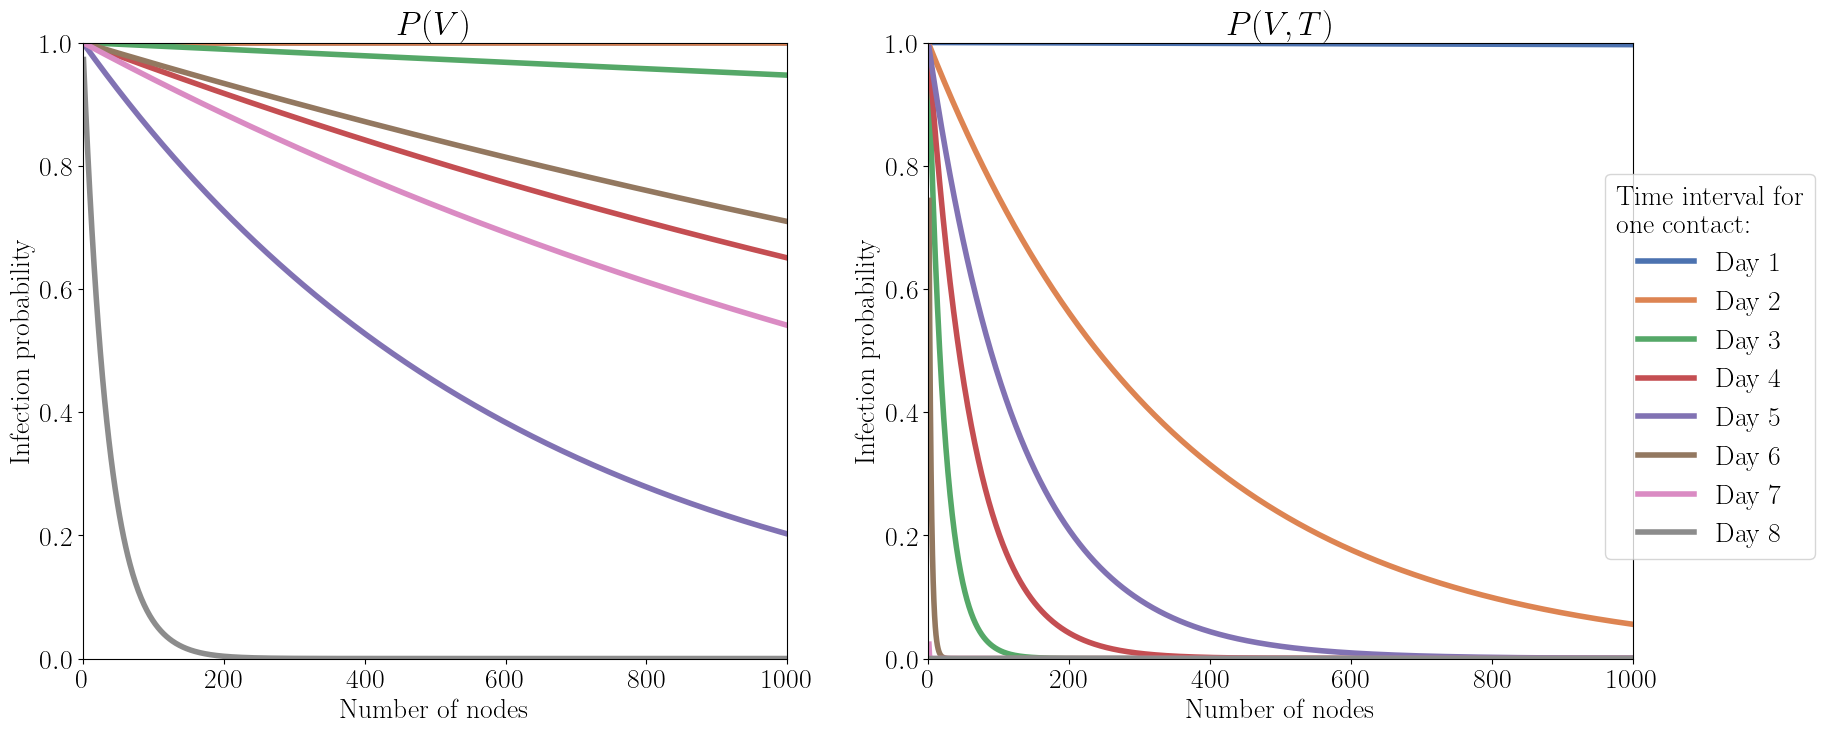

In [20]:
fig, axs = plt.subplots(1,2, figsize=(20,8))

axs[0].plot(xx, yy1_V, linewidth=4, color=palette[0], label='Day 1')
axs[0].plot(xx, yy2_V, linewidth=4, color=palette[1], label='Day 2')
axs[0].plot(xx, yy3_V, linewidth=4, color=palette[2], label='Day 3')
axs[0].plot(xx, yy4_V, linewidth=4, color=palette[3], label='Day 4')
axs[0].plot(xx, yy5_V, linewidth=4, color=palette[4], label='Day 5')
axs[0].plot(xx, yy6_V, linewidth=4, color=palette[5], label='Day 6')
axs[0].plot(xx, yy7_V, linewidth=4, color=palette[6], label='Day 7')
axs[0].plot(xx, yy8_V, linewidth=4, color=palette[7], label='Day 8')
axs[0].set_title('$P(V)$')
axs[0].set(xlim=(0,1000), ylim=(0,1))

axs[0].set_xlabel('Number of nodes')
axs[0].set_ylabel('Infection probability')

axs[1].plot(xx, yy1_T, linewidth=4, color=palette[0], label='Day 1')
axs[1].plot(xx, yy2_T, linewidth=4, color=palette[1], label='Day 2')
axs[1].plot(xx, yy3_T, linewidth=4, color=palette[2], label='Day 3')
axs[1].plot(xx, yy4_T, linewidth=4, color=palette[3], label='Day 4')
axs[1].plot(xx, yy5_T, linewidth=4, color=palette[4], label='Day 5')
axs[1].plot(xx, yy6_T, linewidth=4, color=palette[5], label='Day 6')
axs[1].plot(xx, yy7_T, linewidth=4, color=palette[6], label='Day 7')
axs[1].plot(xx, yy8_T, linewidth=4, color=palette[7], label='Day 8')
axs[1].set_title('$P(V,T)$')
axs[1].set(xlim=(0,1000), ylim=(0,1))

axs[1].set_xlabel('Number of nodes')
axs[1].set_ylabel('Infection probability')

handles, labels = axs[1].get_legend_handles_labels()
fig.legend(handles, labels, loc='center right', title='Time interval for\none contact:')

# plt.savefig('Probabilities.png')

plt.show()

# SDE simulations

In [28]:
import sdeint

In [93]:
def g(y,t):
    # Patient 1: non-severe
    cm = 0.006038
    cg = 0.04077
    tauB = 6.483603
    rM = 0.001248
    q = 0.003339
    rG = 0.000303
    kq = 365.74194
    rQ = 0.009188
    rB = 0.104897
        
    # Fixed parameters
    p = 6.11
    kv = 1e8
    ct = 0.78e-6
    c = 2.4
    rT = 0.281
    kt = 3.16e4
    delT = 0.1
    T0 = 1e6    
    delM = 0.06931
    delG = 0.027725
    
    V, T, B, M, G = y
    if V < 0.0:
        V = 0.0
    if B < 0.0:
        B = 0.0
    if M < 0.0:
        M = 0.0
    if G < 0.0:
        G = 0.0
    
    gg = np.array([[np.sqrt(p*V), -np.sqrt(p*V*V/kv), -np.sqrt(ct*V*T), -np.sqrt(c*V), -np.sqrt(cm*M*V), -np.sqrt(cg*G*V), 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                   [0, 0, 0, 0, 0, 0, np.sqrt(rT*T*(V**2/(V**2 + kt**2))), -np.sqrt(delT*T), np.sqrt(delT*T0), 0, 0, 0, 0, 0, 0, 0, 0],
                   [0, 0, 0, 0, 0, 0, 0, 0, 0, np.sqrt((rB*V)/tauB), -np.sqrt(B/tauB), 0, 0, 0, 0, 0, 0],
                   [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, np.sqrt(rM*B), -np.sqrt((q + delM)*M), 0, 0, 0, 0],
                   [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, np.sqrt(rQ*M), np.sqrt(rQ*M*M/kq), np.sqrt(rG*B), -np.sqrt(delG*G)]])
    
    return gg

In [94]:
V0 = 10.0
T0 = 1e6
B0 = 0.0
M0 = 0.0
G0 = 0.0

intState = np.array([V0, T0, B0, M0, G0])

timeStep = 0.01
endDay = 25
tt = np.arange(0, endDay, timeStep)

In [95]:
levels = sdeint.itoint(within_model, g, intState, tt)

In [96]:
VV = levels[:,0]
TT = levels[:,1]
GG = levels[:,4]

In [103]:
levels = sdeint.itoint(within_model, g, intState, tt)
VV1 = levels[:,0]
TT1 = levels[:,1]
GG1 = levels[:,4]

levels = sdeint.itoint(within_model, g, intState, tt)
VV2 = levels[:,0]
TT2 = levels[:,1]
GG2 = levels[:,4]

levels = sdeint.itoint(within_model, g, intState, tt)
VV3 = levels[:,0]
TT3 = levels[:,1]
GG3 = levels[:,4]

levels = sdeint.itoint(within_model, g, intState, tt)
VV4 = levels[:,0]
TT4 = levels[:,1]
GG4 = levels[:,4]

levels = sdeint.itoint(within_model, g, intState, tt)
VV5 = levels[:,0]
TT5 = levels[:,1]
GG5 = levels[:,4]

levels = sdeint.itoint(within_model, g, intState, tt)
VV6 = levels[:,0]
TT6 = levels[:,1]
GG6 = levels[:,4]

levels = sdeint.itoint(within_model, g, intState, tt)
VV7 = levels[:,0]
TT7 = levels[:,1]
GG7 = levels[:,4]

levels = sdeint.itoint(within_model, g, intState, tt)
VV8 = levels[:,0]
TT8 = levels[:,1]
GG8 = levels[:,4]

levels = sdeint.itoint(within_model, g, intState, tt)
VV9 = levels[:,0]
TT9 = levels[:,1]
GG9 = levels[:,4]

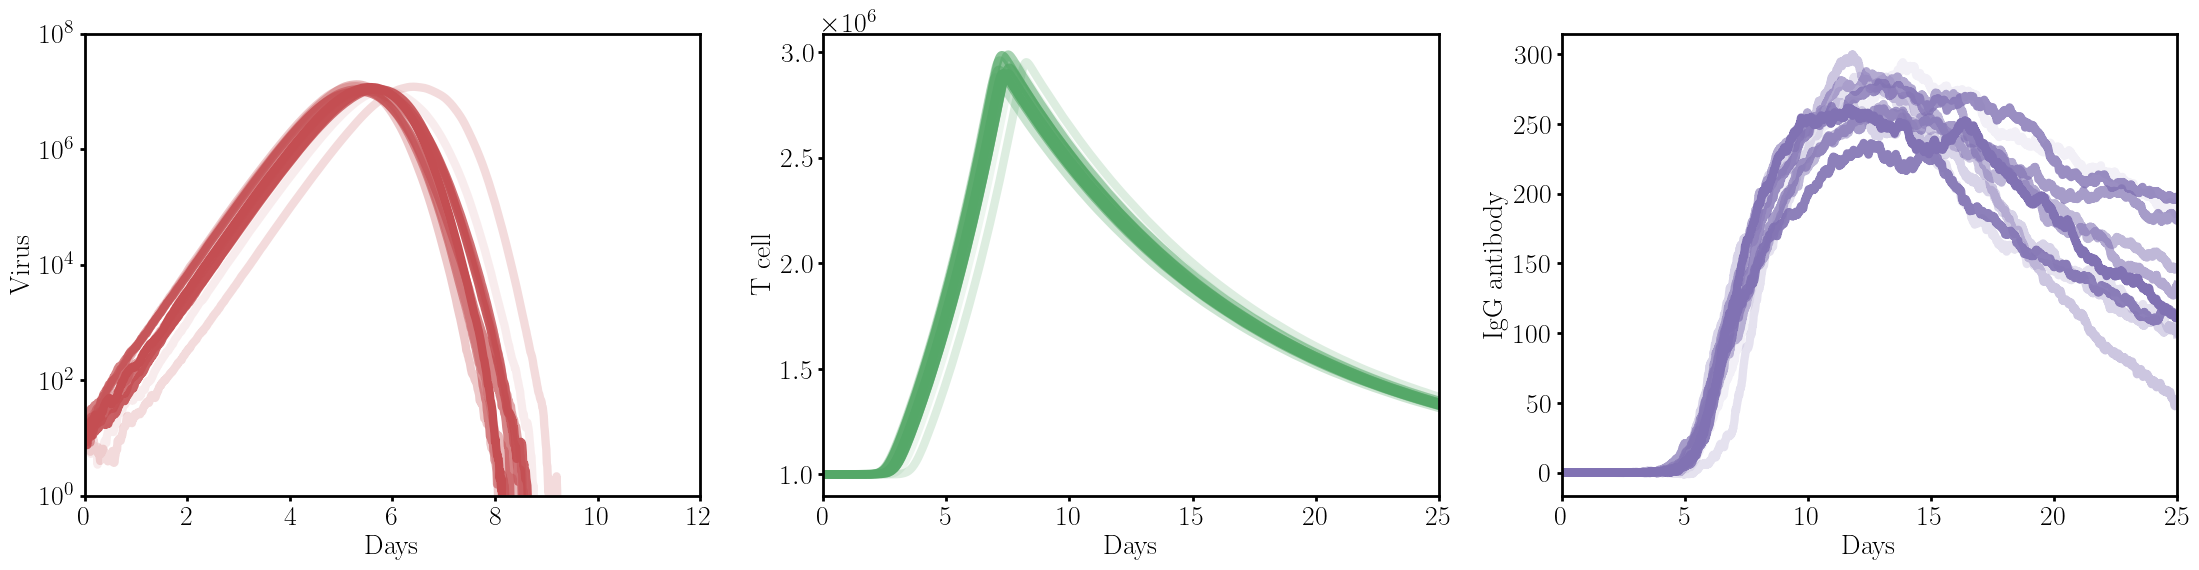

In [104]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(27,6), facecolor='white')

axs[0].plot(tt, VV, lw=6, color=palette[3])
axs[0].plot(tt, VV1, lw=6, color=palette[3], alpha=0.9)
axs[0].plot(tt, VV2, lw=6, color=palette[3], alpha=0.8)
axs[0].plot(tt, VV3, lw=6, color=palette[3], alpha=0.7)
axs[0].plot(tt, VV4, lw=6, color=palette[3], alpha=0.6)
axs[0].plot(tt, VV5, lw=6, color=palette[3], alpha=0.5)
axs[0].plot(tt, VV6, lw=6, color=palette[3], alpha=0.4)
axs[0].plot(tt, VV7, lw=6, color=palette[3], alpha=0.3)
axs[0].plot(tt, VV8, lw=6, color=palette[3], alpha=0.2)
axs[0].plot(tt, VV9, lw=6, color=palette[3], alpha=0.1)
axs[0].set_yscale('log')
axs[0].set_ylim((1,10**8))
axs[0].set_ylabel('Virus')
axs[0].set_xlim((0,12))
axs[0].set_xlabel('Days')

axs[1].plot(tt, TT, lw=6, color=palette[2])
axs[1].plot(tt, TT1, lw=6, color=palette[2], alpha=0.9)
axs[1].plot(tt, TT2, lw=6, color=palette[2], alpha=0.8)
axs[1].plot(tt, TT3, lw=6, color=palette[2], alpha=0.7)
axs[1].plot(tt, TT4, lw=6, color=palette[2], alpha=0.6)
axs[1].plot(tt, TT5, lw=6, color=palette[2], alpha=0.5)
axs[1].plot(tt, TT6, lw=6, color=palette[2], alpha=0.4)
axs[1].plot(tt, TT7, lw=6, color=palette[2], alpha=0.3)
axs[1].plot(tt, TT8, lw=6, color=palette[2], alpha=0.2)
axs[1].plot(tt, TT9, lw=6, color=palette[2], alpha=0.1)
axs[1].set_ylabel('T cell')
axs[1].set_xlim((0,25))
axs[1].set_xlabel('Days')

axs[2].plot(tt, GG, lw=6, color=palette[4])
axs[2].plot(tt, GG1, lw=6, color=palette[4], alpha=0.9)
axs[2].plot(tt, GG2, lw=6, color=palette[4], alpha=0.8)
axs[2].plot(tt, GG3, lw=6, color=palette[4], alpha=0.7)
axs[2].plot(tt, GG4, lw=6, color=palette[4], alpha=0.6)
axs[2].plot(tt, GG5, lw=6, color=palette[4], alpha=0.5)
axs[2].plot(tt, GG6, lw=6, color=palette[4], alpha=0.4)
axs[2].plot(tt, GG7, lw=6, color=palette[4], alpha=0.3)
axs[2].plot(tt, GG8, lw=6, color=palette[4], alpha=0.2)
axs[2].plot(tt, GG9, lw=6, color=palette[4], alpha=0.1)
axs[2].set_ylabel('IgG antibody')
axs[2].set_xlim((0,25))
axs[2].set_xlabel('Days')

for axis in ['top','bottom','left','right']:
    axs[0].spines[axis].set_linewidth(2)
    axs[1].spines[axis].set_linewidth(2)
    axs[2].spines[axis].set_linewidth(2)

axs[0].xaxis.set_tick_params(width=2)
axs[0].yaxis.set_tick_params(width=2)

axs[1].xaxis.set_tick_params(width=2)
axs[1].yaxis.set_tick_params(width=2)

axs[2].xaxis.set_tick_params(width=2)
axs[2].yaxis.set_tick_params(width=2)

# plt.setp(axs, xlim=(0,endDay), xlabel='Days')

# plt.savefig('modelSDE.png')

plt.show()

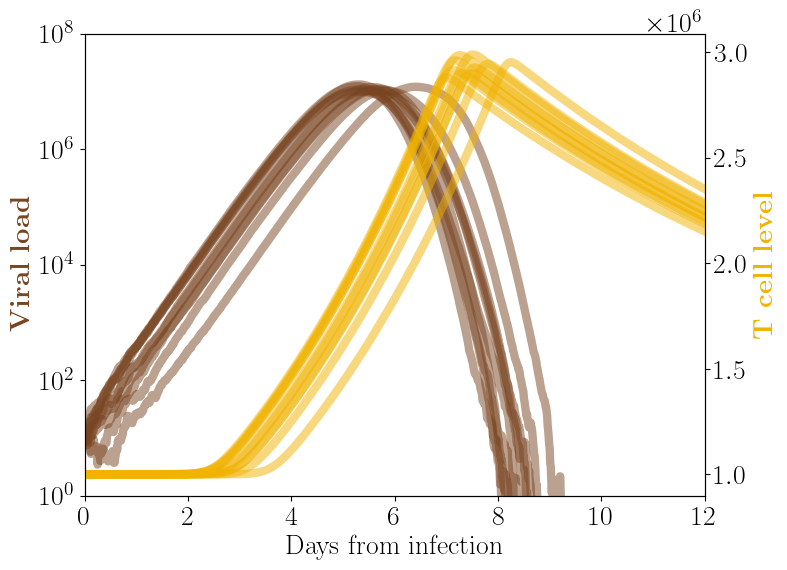

In [109]:
fig, ax1 = plt.subplots(figsize=(8,6), facecolor='white')

ax2 = ax1.twinx()

ax1.plot(tt, VV, lw=6, color=myColors[0], alpha=0.5)
ax1.plot(tt, VV1, lw=6, color=myColors[0], alpha=0.5)
ax1.plot(tt, VV2, lw=6, color=myColors[0], alpha=0.5)
ax1.plot(tt, VV3, lw=6, color=myColors[0], alpha=0.5)
ax1.plot(tt, VV4, lw=6, color=myColors[0], alpha=0.5)
ax1.plot(tt, VV5, lw=6, color=myColors[0], alpha=0.5)
ax1.plot(tt, VV6, lw=6, color=myColors[0], alpha=0.5)
ax1.plot(tt, VV7, lw=6, color=myColors[0], alpha=0.5)
ax1.plot(tt, VV8, lw=6, color=myColors[0], alpha=0.5)
ax1.plot(tt, VV9, lw=6, color=myColors[0], alpha=0.5)
ax1.set_yscale('log')
ax1.set_ylim((1,10**8))
ax1.set_ylabel(r'\textbf{Viral load}', color=myColors[0])
ax1.set_xlim((0,12))
ax1.set_xlabel('Days from infection')

ax2.plot(tt, TT, lw=6, color=myColors[1], alpha=0.5)
ax2.plot(tt, TT1, lw=6, color=myColors[1], alpha=0.5)
ax2.plot(tt, TT2, lw=6, color=myColors[1], alpha=0.5)
ax2.plot(tt, TT3, lw=6, color=myColors[1], alpha=0.5)
ax2.plot(tt, TT4, lw=6, color=myColors[1], alpha=0.5)
ax2.plot(tt, TT5, lw=6, color=myColors[1], alpha=0.5)
ax2.plot(tt, TT6, lw=6, color=myColors[1], alpha=0.5)
ax2.plot(tt, TT7, lw=6, color=myColors[1], alpha=0.5)
ax2.plot(tt, TT8, lw=6, color=myColors[1], alpha=0.5)
ax2.plot(tt, TT9, lw=6, color=myColors[1], alpha=0.5)
ax2.set_ylabel(r'\textbf{T cell level}', color=myColors[1])
ax2.set_xlim((0,12))
ax2.set_xlabel('Days from infection')

# plt.savefig('modelSDE.pdf')

plt.show()

## Estimating probabilty distribution of number of infected nodes

In [130]:
%%time

# Initialize the distributions with the multiplication identity
yy1_V_S = np.zeros(xx.size)
yy2_V_S = np.zeros(xx.size)
yy3_V_S = np.zeros(xx.size)
yy4_V_S = np.zeros(xx.size)
yy5_V_S = np.zeros(xx.size)
yy6_V_S = np.zeros(xx.size)
yy7_V_S = np.zeros(xx.size)
yy8_V_S = np.zeros(xx.size)
yy9_V_S = np.zeros(xx.size)
yy10_V_S = np.zeros(xx.size)
yy11_V_S = np.zeros(xx.size)
yy12_V_S = np.zeros(xx.size)

yy1_T_S = np.zeros(xx.size)
yy2_T_S = np.zeros(xx.size)
yy3_T_S = np.zeros(xx.size)
yy4_T_S = np.zeros(xx.size)
yy5_T_S = np.zeros(xx.size)
yy6_T_S = np.zeros(xx.size)
yy7_T_S = np.zeros(xx.size)
yy8_T_S = np.zeros(xx.size)
yy9_T_S = np.zeros(xx.size)
yy10_T_S = np.zeros(xx.size)
yy11_T_S = np.zeros(xx.size)
yy12_T_S = np.zeros(xx.size)

i = 0
while i < xx.size:    
    if i%50 == 0:
        print(f'{i} nodes simulated')
        
    # Estimate the dynamic of node i
    levels = sdeint.itoint(within_model, g, intState, tt)
    VV = levels[:,0]
    VV[VV < 1] = 1
    if VV.max() < 100:
        continue
    TT = levels[:,1]

    # Estimate the probability in function of time
    probV = sigFunc(np.log10(VV), A_V, K_V)
    probT = 1 - sigFunc(TT, A_T, K_T)
    probVT = probV*probT

    # Get the probability of infection for each day up to 12 days (only V)
    p1 = probV[int(1/timeStep)]
    p2 = probV[int(2/timeStep)]
    p3 = probV[int(3/timeStep)]
    p4 = probV[int(4/timeStep)]
    p5 = probV[int(5/timeStep)]
    p6 = probV[int(6/timeStep)]
    p7 = probV[int(7/timeStep)]
    p8 = probV[int(8/timeStep)]
    p9 = probV[int(9/timeStep)]
    p10 = probV[int(10/timeStep)]
    p11 = probV[int(11/timeStep)]
    p12 = probV[int(12/timeStep)]

    # Estimate the probability of infection of the node i gets infecting
    # if the meeting occurs every X days (e1 means everyday, e2 every 2 days, ...)
    e1 = 1 - (1-p1)*(1-p2)*(1-p3)*(1-p4)*(1-p5)*(1-p6)*(1-p7)*(1-p8)*(1-p9)*(1-p10)*(1-p11)*(1-p12)
    e2 = 1 - (1-p2)*(1-p4)*(1-p6)*(1-p8)*(1-p10)*(1-p12)
    e3 = 1 - (1-p3)*(1-p6)*(1-p9)*(1-p12)
    e4 = 1 - (1-p4)*(1-p8)*(1-p12)
    e5 = 1 - (1-p5)*(1-p10)
    e6 = 1 - (1-p6)*(1-p12)
    e7 = p7
    e8 = p8
    e9 = p9
    e10 = p10
    e11 = p11
    e12 = p12

    yy1_V_S[i] = e1
    yy2_V_S[i] = e2
    yy3_V_S[i] = e3
    yy4_V_S[i] = e4
    yy5_V_S[i] = e5
    yy6_V_S[i] = e6
    yy7_V_S[i] = e7
    yy8_V_S[i] = e8
    yy9_V_S[i] = e9
    yy10_V_S[i] = e10
    yy11_V_S[i] = e11
    yy12_V_S[i] = e12

    # Get the probability of infection for each day up to 12 days (V and T)
    p1 = probVT[int(1/timeStep)]
    p2 = probVT[int(2/timeStep)]
    p3 = probVT[int(3/timeStep)]
    p4 = probVT[int(4/timeStep)]
    p5 = probVT[int(5/timeStep)]
    p6 = probVT[int(6/timeStep)]
    p7 = probVT[int(7/timeStep)]
    p8 = probVT[int(8/timeStep)]
    p9 = probVT[int(9/timeStep)]
    p10 = probVT[int(10/timeStep)]
    p11 = probVT[int(11/timeStep)]
    p12 = probVT[int(12/timeStep)]

    # Estimate the probability of infection of the node i gets infecting
    # if the meeting occurs every X days (e1 means everyday, e2 every 2 days, ...)
    e1 = 1 - (1-p1)*(1-p2)*(1-p3)*(1-p4)*(1-p5)*(1-p6)*(1-p7)*(1-p8)*(1-p9)*(1-p10)*(1-p11)*(1-p12)
    e2 = 1 - (1-p2)*(1-p4)*(1-p6)*(1-p8)*(1-p10)*(1-p12)
    e3 = 1 - (1-p3)*(1-p6)*(1-p9)*(1-p12)
    e4 = 1 - (1-p4)*(1-p8)*(1-p12)
    e5 = 1 - (1-p5)*(1-p10)
    e6 = 1 - (1-p6)*(1-p12)
    e7 = p7
    e8 = p8
    e9 = p9
    e10 = p10
    e11 = p11
    e12 = p12

    yy1_T_S[i] = e1
    yy2_T_S[i] = e2
    yy3_T_S[i] = e3
    yy4_T_S[i] = e4
    yy5_T_S[i] = e5
    yy6_T_S[i] = e6
    yy7_T_S[i] = e7
    yy8_T_S[i] = e8
    yy9_T_S[i] = e9
    yy10_T_S[i] = e10
    yy11_T_S[i] = e11
    yy12_T_S[i] = e12

    i += 1

0 nodes simulated
50 nodes simulated
100 nodes simulated
150 nodes simulated
200 nodes simulated
250 nodes simulated
300 nodes simulated
350 nodes simulated
400 nodes simulated
450 nodes simulated
500 nodes simulated
550 nodes simulated
600 nodes simulated
650 nodes simulated
700 nodes simulated
750 nodes simulated
800 nodes simulated
850 nodes simulated
900 nodes simulated
950 nodes simulated
CPU times: user 22min 18s, sys: 2.78 s, total: 22min 21s
Wall time: 22min 17s


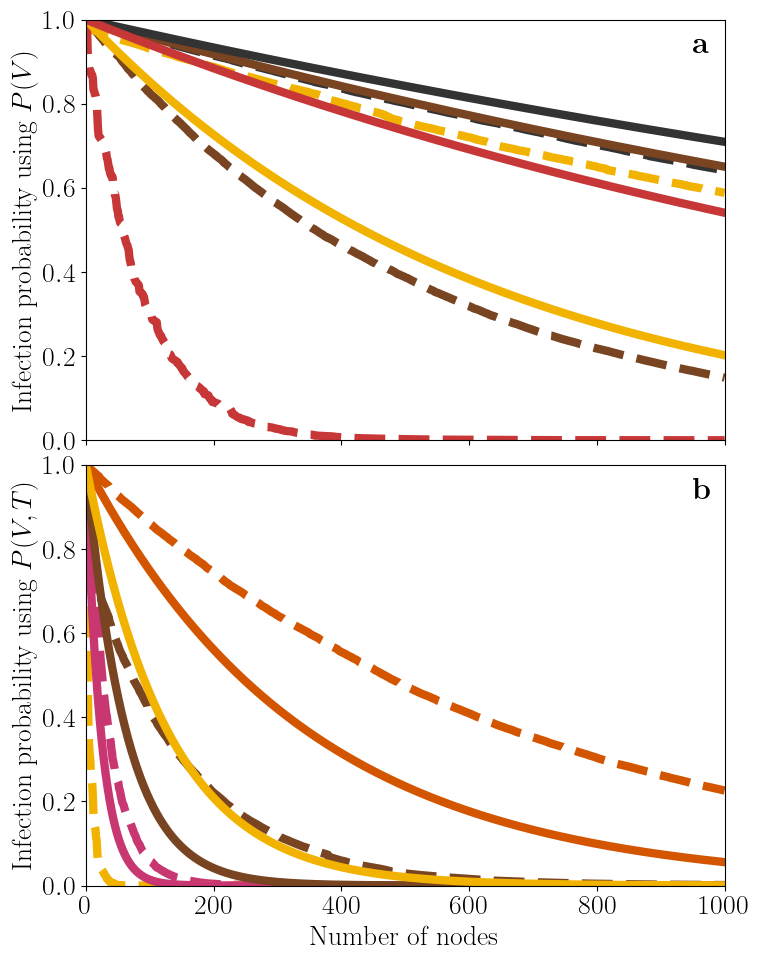

In [23]:
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(8,10), sharex=True)

myPalette = ['#d45500', '#c83771', '#784421', '#f1b300', '#c83737', '#333333']

axs[0].plot(xx, np.cumprod(yy4_V_S), '--', linewidth=6, color=myPalette[2], label='Day 4')
axs[0].plot(xx, np.cumprod(yy5_V_S), '--', linewidth=6, color=myPalette[3], label='Day 5')
axs[0].plot(xx, np.cumprod(yy6_V_S), '--', linewidth=6, color=myPalette[5], label='Day 6')
axs[0].plot(xx, np.cumprod(yy7_V_S), '--', linewidth=6, color=myPalette[4], label='Day 7')

axs[0].plot(xx, yy4_V, linewidth=6, color=myPalette[2], label='Day 4')
axs[0].plot(xx, yy5_V, linewidth=6, color=myPalette[3], label='Day 5')
axs[0].plot(xx, yy6_V, linewidth=6, color=myPalette[5], label='Day 6')
axs[0].plot(xx, yy7_V, linewidth=6, color=myPalette[4], label='Day 7')
axs[0].set(xlim=(0,1000), ylim=(0,1))

axs[0].set_ylabel('Infection probability using $P(V)$')

axs[1].plot(xx, np.cumprod(yy2_T_S), '--', linewidth=6, color=myPalette[0], label='Day 2')
axs[1].plot(xx, np.cumprod(yy3_T_S), '--', linewidth=6, color=myPalette[1], label='Day 3')
axs[1].plot(xx, np.cumprod(yy4_T_S), '--', linewidth=6, color=myPalette[2], label='Day 4')
axs[1].plot(xx, np.cumprod(yy5_T_S), '--', linewidth=6, color=myPalette[3], label='Day 5')

axs[1].plot(xx, yy2_T, linewidth=6, color=myPalette[0], label='Day 2')
axs[1].plot(xx, yy3_T, linewidth=6, color=myPalette[1], label='Day 3')
axs[1].plot(xx, yy4_T, linewidth=6, color=myPalette[2], label='Day 4')
axs[1].plot(xx, yy5_T, linewidth=6, color=myPalette[3], label='Day 5')
axs[1].set(xlim=(0,1000), ylim=(0,1))

axs[1].set_ylabel('Infection probability using $P(V,T)$')
axs[1].set_xlabel('Number of nodes')

axs[0].text(950, 0.92, r'\textbf{a}', fontsize=22)
axs[1].text(950, 0.92, r'\textbf{b}', fontsize=22)

plt.tight_layout(h_pad=0.0)

# plt.savefig('probDist.svg')

plt.show()